In [2]:
import gensim 
import pandas as pd
import logging
import math
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import random


C:\Users\Simo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Preprocessing and feature engineering

In [3]:
songs = pd.read_csv('spotify_dataset.csv', header=None, skiprows=[0], usecols=[0,1,2,3]).dropna()
songs.columns = ['user_id', 'artistname','trackname','playlistname']

In [4]:
display(songs.shape)
display(songs['trackname'].nunique())

(12867139, 4)

2009210

In [5]:
print(songs[songs['artistname'] == 'Pink Floyd'].trackname[0:20].to_string())

896                                         Sorrow - Live
1057                                     Comfortably Numb
1058                              Comfortably Numb - Live
1098                     Echoes - 2011 Remastered Version
1099                    Eclipse - 2011 Remastered Version
1186                                       Hey You - Live
1187                                    High Hopes - Live
1414                    Shine On You Crazy Diamond - Live
1554     Welcome To The Machine - 2011 Remastered Version
1568                 Wish You Were Here - 2011 - Remaster
4193               Brain Damage - 2011 Remastered Version
5123               Echoes - Edit; 2001 Remastered Version
5353                   Fearless - 2011 Remastered Version
7647                      Money - 2011 Remastered Version
10929                                  Wish You Were Here
10930                Wish You Were Here - 2011 - Remaster
11229              Brain Damage - 2011 Remastered Version
12235         

In [6]:
#Every artist can have only one version of the song, reduces unique songs from 2009210 to 1367548

def preprocess_track(trackname):

    trackname = trackname.lower()
    
    
    # everything between [], () is often live remaster etc.
    trackname = re.sub("[\(\[].*?[\)\]]", "", trackname)
    
    #"remove different identifiers only difference of couple of thousand words
    #removed_words = ['radio edit', 'explicit', 'live', 'remaster', 'remastered', 'remix','mix', 'vevo', 'version']
    #for i in removed_words:
    #    trackname = trackname.replace(i, '')
        
    #Remove everything after '-' as they most likely are live, remastered, year etc identifiers
    trackname = trackname.split('-', 1)[0]
    #Remove empty spaces around the trackname
    trackname = trackname.strip()     
       
    return trackname

In [7]:
songs['trackname'] = songs['trackname'].copy().apply(preprocess_track)
#Alternatively only song names to lowercase
#songs['trackname'] = songs['trackname'].map(lambda x: x.lower())
songs['artistname'] = songs['artistname'].map(lambda x: x.lower())

In [8]:
#uniques after preprocessing
songs['trackname'].nunique()

1367548

In [9]:
print(songs[songs['artistname'] == 'pink floyd'].trackname[0:20].to_string())

896                          sorrow
1057               comfortably numb
1058               comfortably numb
1098                         echoes
1099                        eclipse
1186                        hey you
1187                     high hopes
1414     shine on you crazy diamond
1554         welcome to the machine
1568             wish you were here
4193                   brain damage
5123                         echoes
5353                       fearless
7647                          money
10929            wish you were here
10930            wish you were here
11229                  brain damage
12235                         money
12809                         money
28819                one of the few


In [11]:
#Make two new features
#trackartist: identifty the spesific track of the artist to differ between same named songs from different artist (meta2prodvec)
songs["trackartist"] = songs["artistname"] + " - " +songs["trackname"]
#userplaylist to differ between playlists named the same
songs["userplaylist"] = songs["user_id"] + " - " +songs["playlistname"]


In [10]:
songs.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,red shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,"peace, love and understanding",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,tiffany page,7 years too late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,accidents will happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,alison,HARD ROCK 2010


In [12]:
#large increase in unique songs
songs['trackartist'].nunique()

2342855

In [13]:
frequency_of_songs = songs.groupby('trackartist').count()['user_id']

In [14]:
sorted_frequencies = frequency_of_songs.sort_values(ascending=False)

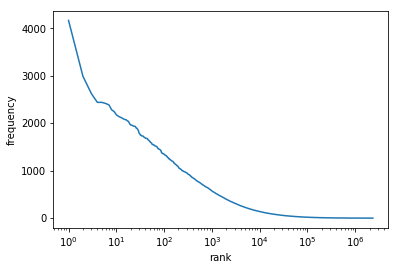

In [28]:
plt.plot(np.arange(1,2342856),sorted_frequencies[0:2342855])
plt.ylabel('frequency')
plt.xlabel('rank')
plt.xscale('log')

plt.show()

In [11]:
#Remove playlist with less than 10 tracks and combine into lists
playlists = songs.groupby(['userplaylist']).filter(lambda x: len(x) >= 10)
playlists = playlists.groupby(['userplaylist']).agg({'trackartist':lambda x: list(x)})

In [12]:
##playlists[playlists.index.str.match('0007f3dd09c91198371454c608d47f22 - Fav songs')]
display(playlists.head())
display(playlists.shape)

,trackartist
userplaylist,
00055176fea33f6e027cd3302289378b - favs,"[jannik brunke - 18, green day - 21 guns, shaw..."
0007f3dd09c91198371454c608d47f22 - Fav songs,"[bryan adams - i do it for you, colourshop - 2..."
000b0f32b5739f052b9d40fcc5c41079 - Contacta,"[veronica maggio - bas gillar hörn, titiyo - b..."
000b0f32b5739f052b9d40fcc5c41079 - Gospel,"[the worship crew - brighter day, oslo gospel ..."
000b0f32b5739f052b9d40fcc5c41079 - Starred,"[java gospel - a blessed christmas eve, java g..."


(188437, 1)

In [13]:
def to_document(playlists):
    documents = []
    for index, row in playlists.iterrows():
        preprocessed_songs = row['trackartist']
        documents.append(preprocessed_songs)

    return documents    

In [14]:
documents = to_document(playlists)
doc_length = len(documents)

## Training Word2vec-music recommender

In [15]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [16]:
#Train with 80 % of the data (with cross validation) and test the final model with 20% of the data
index = np.random.choice(range(doc_length), doc_length, replace=False)
train = np.array(documents)[index[:int(doc_length * 0.8)]].tolist()
test = np.array(documents)[index[int(doc_length * 0.8):]].tolist()

In [17]:
#Help:
#https://github.com/manasRK/word2vec-recommender/blob/master/semsim_train.py
#https://arxiv.org/abs/1804.04212
#http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
#https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words

In [18]:
#initial parameteres from https://arxiv.org/abs/1804.04212
window_size=7
it=90#increasing this leads to returning words with high similarity
sample=0.001 
power_alpha=-0.5

size_embedding=50
neg_sample=5
workers=10
min_count=10

#sg 0 == cbow
#sg1 == skip gram
sg_type=1

model = gensim.models.Word2Vec(train, size=size_embedding, window=window_size,
                 min_count=min_count, workers=workers, sg=1, iter=it,
                 sample=sample, negative=neg_sample, alpha=power_alpha)

model.train(train,total_examples=len(train), epochs=model.iter)

2019-03-20 13:47:32,612 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-03-20 13:47:32,613 : INFO : collecting all words and their counts
2019-03-20 13:47:32,614 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-20 13:47:32,934 : INFO : PROGRESS: at sentence #10000, processed 674897 words, keeping 343173 word types
2019-03-20 13:47:33,279 : INFO : PROGRESS: at sentence #20000, processed 1296920 words, keeping 551364 word types
2019-03-20 13:47:33,710 : INFO : PROGRESS: at sentence #30000, processed 1999431 words, keeping 746651 word types
2019-03-20 13:47:34,060 : INFO : PROGRESS: at sentence #40000, processed 2642321 words, keeping 884655 word types
2019-03-20 13:47:34,399 : INFO : PROGRESS: at sentence #50000, processed 3256670 words, keeping 1011233 word types
2019-03-20 13:47:34,821 : INFO : PROGRESS: at sentence #60000, processed 3952387 words, keeping 1157794 word types
2019-03-20 13:47:35,250 : INFO : PROGR

2019-03-20 13:48:14,444 : INFO : EPOCH 3 - PROGRESS: at 21.99% examples, 461037 words/s, in_qsize 20, out_qsize 1
2019-03-20 13:48:15,452 : INFO : EPOCH 3 - PROGRESS: at 30.15% examples, 467568 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:48:16,458 : INFO : EPOCH 3 - PROGRESS: at 37.14% examples, 467809 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:48:17,481 : INFO : EPOCH 3 - PROGRESS: at 44.47% examples, 464275 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:48:18,516 : INFO : EPOCH 3 - PROGRESS: at 52.40% examples, 466051 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:48:19,517 : INFO : EPOCH 3 - PROGRESS: at 59.12% examples, 466993 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:48:20,535 : INFO : EPOCH 3 - PROGRESS: at 66.44% examples, 467712 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:48:21,547 : INFO : EPOCH 3 - PROGRESS: at 73.39% examples, 468420 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:48:22,551 : INFO : EPOCH 3 - PROGRESS: at 80.51% examples, 467743 words/s,

2019-03-20 13:49:01,641 : INFO : EPOCH 6 - PROGRESS: at 66.80% examples, 472607 words/s, in_qsize 17, out_qsize 2
2019-03-20 13:49:02,688 : INFO : EPOCH 6 - PROGRESS: at 73.92% examples, 471583 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:49:03,705 : INFO : EPOCH 6 - PROGRESS: at 81.49% examples, 472543 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:49:04,708 : INFO : EPOCH 6 - PROGRESS: at 88.65% examples, 472230 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:49:05,735 : INFO : EPOCH 6 - PROGRESS: at 96.24% examples, 471773 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:49:06,075 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 13:49:06,087 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 13:49:06,092 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 13:49:06,099 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 13:49:06,118 : INFO : worker thread finished; awaiting 

2019-03-20 13:49:47,089 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 13:49:47,104 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 13:49:47,109 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 13:49:47,132 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 13:49:47,134 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 13:49:47,152 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 13:49:47,154 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 13:49:47,164 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 13:49:47,180 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 13:49:47,180 : INFO : EPOCH - 9 : training on 10153280 raw words (6451601 effective words) took 13.7s, 472133 effective words/s
2019-03-20 13:49:48,196 : INFO : EPOCH 10 

2019-03-20 13:50:28,277 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 13:50:28,284 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 13:50:28,285 : INFO : EPOCH - 12 : training on 10153280 raw words (6451601 effective words) took 13.7s, 470106 effective words/s
2019-03-20 13:50:29,293 : INFO : EPOCH 13 - PROGRESS: at 6.90% examples, 444021 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:50:30,314 : INFO : EPOCH 13 - PROGRESS: at 14.76% examples, 456794 words/s, in_qsize 20, out_qsize 1
2019-03-20 13:50:31,324 : INFO : EPOCH 13 - PROGRESS: at 22.10% examples, 465094 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:50:32,325 : INFO : EPOCH 13 - PROGRESS: at 30.29% examples, 471124 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:50:33,340 : INFO : EPOCH 13 - PROGRESS: at 37.22% examples, 469709 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:50:34,356 : INFO : EPOCH 13 - PROGRESS: at 44.75% examples, 468274 words/s, in_qsize 20, o

2019-03-20 13:51:13,459 : INFO : EPOCH 16 - PROGRESS: at 28.45% examples, 442960 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:51:14,460 : INFO : EPOCH 16 - PROGRESS: at 35.84% examples, 448694 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:51:15,471 : INFO : EPOCH 16 - PROGRESS: at 43.26% examples, 452110 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:51:16,480 : INFO : EPOCH 16 - PROGRESS: at 51.10% examples, 456303 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:51:17,484 : INFO : EPOCH 16 - PROGRESS: at 58.11% examples, 457754 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:51:18,489 : INFO : EPOCH 16 - PROGRESS: at 64.90% examples, 458757 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:51:19,513 : INFO : EPOCH 16 - PROGRESS: at 71.68% examples, 456958 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:51:20,527 : INFO : EPOCH 16 - PROGRESS: at 78.14% examples, 453503 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:51:21,549 : INFO : EPOCH 16 - PROGRESS: at 84.65% examples, 451834

2019-03-20 13:51:59,352 : INFO : EPOCH 19 - PROGRESS: at 59.12% examples, 470249 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:52:00,374 : INFO : EPOCH 19 - PROGRESS: at 66.32% examples, 469787 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:52:01,391 : INFO : EPOCH 19 - PROGRESS: at 73.44% examples, 470509 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:52:02,398 : INFO : EPOCH 19 - PROGRESS: at 80.62% examples, 470178 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:52:03,407 : INFO : EPOCH 19 - PROGRESS: at 88.08% examples, 471497 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:52:04,424 : INFO : EPOCH 19 - PROGRESS: at 95.74% examples, 471363 words/s, in_qsize 20, out_qsize 2
2019-03-20 13:52:04,859 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 13:52:04,863 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 13:52:04,874 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 13:52:04,879 : INFO : work

2019-03-20 13:52:45,291 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 13:52:45,292 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 13:52:45,297 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 13:52:45,300 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 13:52:45,327 : INFO : EPOCH 22 - PROGRESS: at 99.42% examples, 488687 words/s, in_qsize 5, out_qsize 1
2019-03-20 13:52:45,327 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 13:52:45,337 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 13:52:45,367 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 13:52:45,375 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 13:52:45,383 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 13:52:45,396 : INFO : worker thread finished; awaiting f

2019-03-20 13:53:25,473 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 13:53:25,491 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 13:53:25,508 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 13:53:25,509 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 13:53:25,513 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 13:53:25,514 : INFO : EPOCH - 25 : training on 10153280 raw words (6451601 effective words) took 13.3s, 483970 effective words/s
2019-03-20 13:53:26,546 : INFO : EPOCH 26 - PROGRESS: at 7.35% examples, 455935 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:53:27,554 : INFO : EPOCH 26 - PROGRESS: at 15.59% examples, 480471 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:53:28,568 : INFO : EPOCH 26 - PROGRESS: at 23.11% examples, 483314 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:53:29,590 : INFO : EPOCH 26 - PROGRESS: at 31.4

2019-03-20 13:54:06,128 : INFO : EPOCH 29 - PROGRESS: at 7.00% examples, 444616 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:54:07,154 : INFO : EPOCH 29 - PROGRESS: at 15.38% examples, 473953 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:54:08,189 : INFO : EPOCH 29 - PROGRESS: at 22.86% examples, 474676 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:54:09,215 : INFO : EPOCH 29 - PROGRESS: at 31.40% examples, 481808 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:54:10,217 : INFO : EPOCH 29 - PROGRESS: at 38.36% examples, 479509 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:54:11,222 : INFO : EPOCH 29 - PROGRESS: at 46.59% examples, 482143 words/s, in_qsize 17, out_qsize 2
2019-03-20 13:54:12,246 : INFO : EPOCH 29 - PROGRESS: at 54.03% examples, 480661 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:54:13,258 : INFO : EPOCH 29 - PROGRESS: at 61.42% examples, 483979 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:54:14,259 : INFO : EPOCH 29 - PROGRESS: at 68.59% examples, 482758 

2019-03-20 13:54:50,779 : INFO : EPOCH 32 - PROGRESS: at 46.35% examples, 486197 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:54:51,811 : INFO : EPOCH 32 - PROGRESS: at 53.93% examples, 484768 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:54:52,824 : INFO : EPOCH 32 - PROGRESS: at 61.13% examples, 486130 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:54:53,840 : INFO : EPOCH 32 - PROGRESS: at 68.59% examples, 485786 words/s, in_qsize 20, out_qsize 1
2019-03-20 13:54:54,843 : INFO : EPOCH 32 - PROGRESS: at 76.00% examples, 486551 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:54:55,856 : INFO : EPOCH 32 - PROGRESS: at 83.22% examples, 486440 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:54:56,860 : INFO : EPOCH 32 - PROGRESS: at 90.99% examples, 487228 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:54:57,853 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 13:54:57,874 : INFO : EPOCH 32 - PROGRESS: at 99.15% examples, 487849 words/s, in_qsize 8, ou

2019-03-20 13:55:35,511 : INFO : EPOCH 35 - PROGRESS: at 83.25% examples, 484862 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:55:36,517 : INFO : EPOCH 35 - PROGRESS: at 91.22% examples, 486354 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:55:37,483 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 13:55:37,508 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 13:55:37,518 : INFO : EPOCH 35 - PROGRESS: at 99.18% examples, 486862 words/s, in_qsize 7, out_qsize 1
2019-03-20 13:55:37,519 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 13:55:37,523 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 13:55:37,530 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 13:55:37,541 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 13:55:37,559 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 13:55:37

2019-03-20 13:56:17,543 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 13:56:17,565 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 13:56:17,575 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 13:56:17,613 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 13:56:17,629 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 13:56:17,634 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 13:56:17,638 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 13:56:17,639 : INFO : EPOCH - 38 : training on 10153280 raw words (6451601 effective words) took 13.3s, 485294 effective words/s
2019-03-20 13:56:18,648 : INFO : EPOCH 39 - PROGRESS: at 7.46% examples, 474243 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:56:19,651 : INFO : EPOCH 39 - PROGRESS: at 15.46% examples, 484425 words/s, in_qsize 18, out_qs

2019-03-20 13:56:58,203 : INFO : EPOCH 42 - PROGRESS: at 6.66% examples, 429616 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:56:59,220 : INFO : EPOCH 42 - PROGRESS: at 14.57% examples, 448075 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:57:00,245 : INFO : EPOCH 42 - PROGRESS: at 21.74% examples, 456173 words/s, in_qsize 20, out_qsize 1
2019-03-20 13:57:01,245 : INFO : EPOCH 42 - PROGRESS: at 29.61% examples, 460003 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:57:02,261 : INFO : EPOCH 42 - PROGRESS: at 36.77% examples, 462123 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:57:03,268 : INFO : EPOCH 42 - PROGRESS: at 44.33% examples, 463954 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:57:04,276 : INFO : EPOCH 42 - PROGRESS: at 52.02% examples, 464730 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:57:05,306 : INFO : EPOCH 42 - PROGRESS: at 58.91% examples, 463719 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:57:06,317 : INFO : EPOCH 42 - PROGRESS: at 66.03% examples, 465605 

2019-03-20 13:57:44,098 : INFO : EPOCH 45 - PROGRESS: at 44.47% examples, 463225 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:57:45,101 : INFO : EPOCH 45 - PROGRESS: at 52.09% examples, 464279 words/s, in_qsize 17, out_qsize 2
2019-03-20 13:57:46,106 : INFO : EPOCH 45 - PROGRESS: at 58.70% examples, 462472 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:57:47,113 : INFO : EPOCH 45 - PROGRESS: at 65.61% examples, 462998 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:57:48,117 : INFO : EPOCH 45 - PROGRESS: at 72.54% examples, 463086 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:57:49,133 : INFO : EPOCH 45 - PROGRESS: at 79.77% examples, 464158 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:57:50,164 : INFO : EPOCH 45 - PROGRESS: at 86.80% examples, 463094 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:57:51,203 : INFO : EPOCH 45 - PROGRESS: at 94.73% examples, 463853 words/s, in_qsize 17, out_qsize 2
2019-03-20 13:57:51,776 : INFO : worker thread finished; awaiting finish of 9 mo

2019-03-20 13:58:30,016 : INFO : EPOCH 48 - PROGRESS: at 70.18% examples, 448194 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:58:31,028 : INFO : EPOCH 48 - PROGRESS: at 77.38% examples, 450018 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:58:32,029 : INFO : EPOCH 48 - PROGRESS: at 84.18% examples, 451108 words/s, in_qsize 20, out_qsize 0
2019-03-20 13:58:33,029 : INFO : EPOCH 48 - PROGRESS: at 92.04% examples, 453973 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:58:33,978 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 13:58:33,984 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 13:58:33,999 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 13:58:34,000 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 13:58:34,018 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 13:58:34,036 : INFO : EPOCH 48 - PROGRESS: at 99.55% examples, 454738 word

2019-03-20 13:59:15,266 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 13:59:15,277 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 13:59:15,278 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 13:59:15,279 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 13:59:15,306 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 13:59:15,309 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 13:59:15,355 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 13:59:15,365 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 13:59:15,374 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 13:59:15,375 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 13:59:15,375 : INFO : EPOCH - 51 : training on 10153280 raw words (6451601 effe

2019-03-20 13:59:56,531 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 13:59:56,536 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 13:59:56,540 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 13:59:56,541 : INFO : EPOCH - 54 : training on 10153280 raw words (6451601 effective words) took 13.7s, 471492 effective words/s
2019-03-20 13:59:57,554 : INFO : EPOCH 55 - PROGRESS: at 7.02% examples, 448784 words/s, in_qsize 19, out_qsize 0
2019-03-20 13:59:58,555 : INFO : EPOCH 55 - PROGRESS: at 14.79% examples, 460539 words/s, in_qsize 18, out_qsize 1
2019-03-20 13:59:59,576 : INFO : EPOCH 55 - PROGRESS: at 21.99% examples, 463069 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:00:00,584 : INFO : EPOCH 55 - PROGRESS: at 30.29% examples, 470811 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:00:01,623 : INFO : EPOCH 55 - PROGRESS: at 37.37% examples, 468626 words/s, in_qsize 20, out_qsize 0
2019-03-20 14

2019-03-20 14:00:41,457 : INFO : EPOCH 58 - PROGRESS: at 22.15% examples, 466264 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:00:42,464 : INFO : EPOCH 58 - PROGRESS: at 30.15% examples, 468441 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:00:43,514 : INFO : EPOCH 58 - PROGRESS: at 37.34% examples, 466802 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:00:44,565 : INFO : EPOCH 58 - PROGRESS: at 45.29% examples, 467588 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:00:45,584 : INFO : EPOCH 58 - PROGRESS: at 52.89% examples, 467227 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:00:46,602 : INFO : EPOCH 58 - PROGRESS: at 58.83% examples, 458853 words/s, in_qsize 17, out_qsize 2
2019-03-20 14:00:47,605 : INFO : EPOCH 58 - PROGRESS: at 65.56% examples, 459180 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:00:48,616 : INFO : EPOCH 58 - PROGRESS: at 72.48% examples, 458987 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:00:49,622 : INFO : EPOCH 58 - PROGRESS: at 79.26% examples, 457692

2019-03-20 14:01:27,495 : INFO : EPOCH 61 - PROGRESS: at 61.52% examples, 486603 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:01:28,497 : INFO : EPOCH 61 - PROGRESS: at 69.01% examples, 487787 words/s, in_qsize 20, out_qsize 2
2019-03-20 14:01:29,508 : INFO : EPOCH 61 - PROGRESS: at 76.51% examples, 488507 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:01:30,527 : INFO : EPOCH 61 - PROGRESS: at 83.90% examples, 488986 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:01:31,530 : INFO : EPOCH 61 - PROGRESS: at 91.59% examples, 488330 words/s, in_qsize 19, out_qsize 1
2019-03-20 14:01:32,464 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:01:32,480 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:01:32,491 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:01:32,493 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:01:32,500 : INFO : worker thread finished; awai

2019-03-20 14:02:12,192 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:02:12,195 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:02:12,197 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:02:12,201 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:02:12,229 : INFO : EPOCH 64 - PROGRESS: at 99.44% examples, 488786 words/s, in_qsize 5, out_qsize 1
2019-03-20 14:02:12,230 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:02:12,248 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:02:12,270 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:02:12,281 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:02:12,283 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:02:12,299 : INFO : worker thread finished; awaiting f

2019-03-20 14:02:52,105 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:02:52,115 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:02:52,119 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:02:52,120 : INFO : EPOCH - 67 : training on 10153280 raw words (6451601 effective words) took 13.4s, 482343 effective words/s
2019-03-20 14:02:53,131 : INFO : EPOCH 68 - PROGRESS: at 7.11% examples, 454831 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:02:54,142 : INFO : EPOCH 68 - PROGRESS: at 15.16% examples, 471094 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:02:55,144 : INFO : EPOCH 68 - PROGRESS: at 22.65% examples, 480106 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:02:56,157 : INFO : EPOCH 68 - PROGRESS: at 30.75% examples, 479466 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:02:57,158 : INFO : EPOCH 68 - PROGRESS: at 38.07% examples, 481966 words/s, in_qsize 20, out_qsize 1
2019-03-20 14

2019-03-20 14:03:35,968 : INFO : EPOCH 71 - PROGRESS: at 22.21% examples, 465500 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:03:36,974 : INFO : EPOCH 71 - PROGRESS: at 30.40% examples, 470871 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:03:37,993 : INFO : EPOCH 71 - PROGRESS: at 36.86% examples, 462884 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:03:39,012 : INFO : EPOCH 71 - PROGRESS: at 44.47% examples, 463716 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:03:40,018 : INFO : EPOCH 71 - PROGRESS: at 52.16% examples, 465443 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:03:41,036 : INFO : EPOCH 71 - PROGRESS: at 59.03% examples, 465620 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:03:42,037 : INFO : EPOCH 71 - PROGRESS: at 65.76% examples, 464174 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:03:43,040 : INFO : EPOCH 71 - PROGRESS: at 72.75% examples, 464282 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:03:44,082 : INFO : EPOCH 71 - PROGRESS: at 80.05% examples, 464582

2019-03-20 14:04:22,173 : INFO : EPOCH 74 - PROGRESS: at 59.62% examples, 470220 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:04:23,183 : INFO : EPOCH 74 - PROGRESS: at 66.80% examples, 470575 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:04:24,215 : INFO : EPOCH 74 - PROGRESS: at 73.92% examples, 470462 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:04:25,226 : INFO : EPOCH 74 - PROGRESS: at 81.24% examples, 470481 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:04:26,249 : INFO : EPOCH 74 - PROGRESS: at 88.77% examples, 471254 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:04:27,265 : INFO : EPOCH 74 - PROGRESS: at 96.32% examples, 471233 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:04:27,586 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:04:27,595 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:04:27,607 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:04:27,620 : INFO : work

2019-03-20 14:05:08,243 : INFO : EPOCH 77 - PROGRESS: at 97.63% examples, 480939 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:05:08,386 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:05:08,396 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:05:08,403 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:05:08,405 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:05:08,428 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:05:08,446 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:05:08,447 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:05:08,462 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:05:08,474 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:05:08,481 : INFO : worker thread finished; awaiting 

2019-03-20 14:05:49,610 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:05:49,625 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:05:49,642 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:05:49,648 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:05:49,660 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:05:49,660 : INFO : EPOCH - 80 : training on 10153280 raw words (6451601 effective words) took 13.8s, 468287 effective words/s
2019-03-20 14:05:50,669 : INFO : EPOCH 81 - PROGRESS: at 6.66% examples, 430955 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:05:51,678 : INFO : EPOCH 81 - PROGRESS: at 14.69% examples, 456249 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:05:52,693 : INFO : EPOCH 81 - PROGRESS: at 21.78% examples, 459495 words/s, in_qsize 19, out_qsize 1
2019-03-20 14:05:53,713 : INFO : EPOCH 81 - PROGRESS: at 29.9

2019-03-20 14:06:31,818 : INFO : EPOCH 84 - PROGRESS: at 6.88% examples, 435327 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:06:32,822 : INFO : EPOCH 84 - PROGRESS: at 14.98% examples, 463409 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:06:33,822 : INFO : EPOCH 84 - PROGRESS: at 21.99% examples, 463771 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:06:34,832 : INFO : EPOCH 84 - PROGRESS: at 30.29% examples, 471021 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:06:35,841 : INFO : EPOCH 84 - PROGRESS: at 37.34% examples, 471315 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:06:36,851 : INFO : EPOCH 84 - PROGRESS: at 44.94% examples, 471305 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:06:37,886 : INFO : EPOCH 84 - PROGRESS: at 52.82% examples, 471283 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:06:38,886 : INFO : EPOCH 84 - PROGRESS: at 59.39% examples, 470725 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:06:39,888 : INFO : EPOCH 84 - PROGRESS: at 66.73% examples, 472113 

2019-03-20 14:07:17,820 : INFO : EPOCH 87 - PROGRESS: at 44.47% examples, 465004 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:07:18,844 : INFO : EPOCH 87 - PROGRESS: at 52.40% examples, 467300 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:07:19,867 : INFO : EPOCH 87 - PROGRESS: at 59.22% examples, 467683 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:07:20,876 : INFO : EPOCH 87 - PROGRESS: at 66.44% examples, 468219 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:07:21,888 : INFO : EPOCH 87 - PROGRESS: at 73.31% examples, 468132 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:07:22,895 : INFO : EPOCH 87 - PROGRESS: at 80.62% examples, 468528 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:07:23,923 : INFO : EPOCH 87 - PROGRESS: at 88.08% examples, 469218 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:07:24,924 : INFO : EPOCH 87 - PROGRESS: at 95.50% examples, 468314 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:07:25,392 : INFO : worker thread finished; awaiting finish of 9 mo

2019-03-20 14:08:04,007 : INFO : EPOCH 90 - PROGRESS: at 80.72% examples, 469109 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:08:05,024 : INFO : EPOCH 90 - PROGRESS: at 88.17% examples, 470187 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:08:06,033 : INFO : EPOCH 90 - PROGRESS: at 96.05% examples, 471587 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:08:06,428 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:08:06,432 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:08:06,443 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:08:06,463 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:08:06,472 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:08:06,476 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:08:06,509 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:08:0

2019-03-20 14:08:47,121 : INFO : EPOCH 3 - PROGRESS: at 95.29% examples, 467704 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:08:47,641 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:08:47,655 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:08:47,659 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:08:47,666 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:08:47,693 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:08:47,699 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:08:47,733 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:08:47,742 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:08:47,743 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:08:47,753 : INFO : worker thread finished; awaiting f

2019-03-20 14:09:28,902 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:09:28,915 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:09:28,916 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:09:28,934 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:09:28,934 : INFO : EPOCH - 6 : training on 10153280 raw words (6451601 effective words) took 13.8s, 466220 effective words/s
2019-03-20 14:09:29,948 : INFO : EPOCH 7 - PROGRESS: at 6.90% examples, 441413 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:09:30,949 : INFO : EPOCH 7 - PROGRESS: at 14.79% examples, 460377 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:09:31,995 : INFO : EPOCH 7 - PROGRESS: at 21.99% examples, 459247 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:09:33,024 : INFO : EPOCH 7 - PROGRESS: at 30.40% examples, 466956 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:09:34,038 : INFO : EPOCH 7 -

2019-03-20 14:10:12,098 : INFO : EPOCH 10 - PROGRESS: at 14.93% examples, 460161 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:10:13,114 : INFO : EPOCH 10 - PROGRESS: at 22.26% examples, 466396 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:10:14,131 : INFO : EPOCH 10 - PROGRESS: at 30.49% examples, 470215 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:10:15,139 : INFO : EPOCH 10 - PROGRESS: at 37.37% examples, 468519 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:10:16,170 : INFO : EPOCH 10 - PROGRESS: at 45.21% examples, 469335 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:10:17,210 : INFO : EPOCH 10 - PROGRESS: at 52.93% examples, 468322 words/s, in_qsize 18, out_qsize 2
2019-03-20 14:10:18,226 : INFO : EPOCH 10 - PROGRESS: at 59.72% examples, 468688 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:10:19,229 : INFO : EPOCH 10 - PROGRESS: at 67.12% examples, 470936 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:10:20,264 : INFO : EPOCH 10 - PROGRESS: at 73.92% examples, 468774

2019-03-20 14:10:58,260 : INFO : EPOCH 13 - PROGRESS: at 52.49% examples, 467093 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:10:59,265 : INFO : EPOCH 13 - PROGRESS: at 59.12% examples, 466923 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:11:00,274 : INFO : EPOCH 13 - PROGRESS: at 66.22% examples, 466686 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:11:01,274 : INFO : EPOCH 13 - PROGRESS: at 73.14% examples, 466944 words/s, in_qsize 17, out_qsize 2
2019-03-20 14:11:02,287 : INFO : EPOCH 13 - PROGRESS: at 80.40% examples, 467625 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:11:03,292 : INFO : EPOCH 13 - PROGRESS: at 87.71% examples, 468285 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:11:04,317 : INFO : EPOCH 13 - PROGRESS: at 95.50% examples, 468481 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:11:04,770 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:11:04,779 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14

2019-03-20 14:11:44,408 : INFO : EPOCH 16 - PROGRESS: at 85.98% examples, 458590 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:11:45,409 : INFO : EPOCH 16 - PROGRESS: at 93.46% examples, 459551 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:11:46,165 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:11:46,166 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:11:46,167 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:11:46,196 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:11:46,203 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:11:46,204 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:11:46,244 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:11:46,257 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:11:46,264 : INFO : worker th

2019-03-20 14:12:27,845 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:12:27,850 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:12:27,856 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:12:27,874 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:12:27,875 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:12:27,899 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:12:27,900 : INFO : EPOCH - 19 : training on 10153280 raw words (6451601 effective words) took 13.7s, 470916 effective words/s
2019-03-20 14:12:28,908 : INFO : EPOCH 20 - PROGRESS: at 6.66% examples, 430864 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:12:29,912 : INFO : EPOCH 20 - PROGRESS: at 14.61% examples, 455015 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:12:30,912 : INFO : EPOCH 20 - PROGRESS: at 21.64% examples, 460357 word

2019-03-20 14:13:10,621 : INFO : EPOCH 23 - PROGRESS: at 6.90% examples, 430397 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:13:11,628 : INFO : EPOCH 23 - PROGRESS: at 14.86% examples, 456181 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:13:12,647 : INFO : EPOCH 23 - PROGRESS: at 21.99% examples, 458437 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:13:13,678 : INFO : EPOCH 23 - PROGRESS: at 30.29% examples, 464628 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:13:14,697 : INFO : EPOCH 23 - PROGRESS: at 37.34% examples, 465249 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:13:15,716 : INFO : EPOCH 23 - PROGRESS: at 45.07% examples, 466567 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:13:16,736 : INFO : EPOCH 23 - PROGRESS: at 52.82% examples, 467292 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:13:17,740 : INFO : EPOCH 23 - PROGRESS: at 59.62% examples, 468460 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:13:18,741 : INFO : EPOCH 23 - PROGRESS: at 66.43% examples, 466968 

2019-03-20 14:13:57,054 : INFO : EPOCH 26 - PROGRESS: at 44.20% examples, 464497 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:13:58,055 : INFO : EPOCH 26 - PROGRESS: at 52.10% examples, 467750 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:13:59,055 : INFO : EPOCH 26 - PROGRESS: at 58.83% examples, 466312 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:14:00,075 : INFO : EPOCH 26 - PROGRESS: at 65.76% examples, 466350 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:14:01,081 : INFO : EPOCH 26 - PROGRESS: at 72.96% examples, 468096 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:14:02,111 : INFO : EPOCH 26 - PROGRESS: at 80.05% examples, 466730 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:14:03,130 : INFO : EPOCH 26 - PROGRESS: at 87.46% examples, 467888 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:14:04,145 : INFO : EPOCH 26 - PROGRESS: at 95.35% examples, 468635 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:14:04,610 : INFO : worker thread finished; awaiting finish of 9 mo

2019-03-20 14:14:43,344 : INFO : EPOCH 29 - PROGRESS: at 80.71% examples, 469331 words/s, in_qsize 16, out_qsize 3
2019-03-20 14:14:44,347 : INFO : EPOCH 29 - PROGRESS: at 88.00% examples, 469780 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:14:45,360 : INFO : EPOCH 29 - PROGRESS: at 95.74% examples, 470387 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:14:45,804 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:14:45,815 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:14:45,819 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:14:45,827 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:14:45,842 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:14:45,856 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:14:45,895 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:14:4

2019-03-20 14:15:26,929 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:15:26,959 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:15:26,961 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:15:26,977 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:15:26,996 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:15:26,998 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:15:27,011 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:15:27,012 : INFO : EPOCH - 32 : training on 10153280 raw words (6451601 effective words) took 13.7s, 471838 effective words/s
2019-03-20 14:15:28,032 : INFO : EPOCH 33 - PROGRESS: at 6.90% examples, 439033 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:15:29,040 : INFO : EPOCH 33 - PROGRESS: at 14.97% examples, 463619 words/s, in_qsize 19, out_qs

2019-03-20 14:16:08,137 : INFO : EPOCH - 35 : training on 10153280 raw words (6451601 effective words) took 13.7s, 471212 effective words/s
2019-03-20 14:16:09,161 : INFO : EPOCH 36 - PROGRESS: at 6.90% examples, 437176 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:16:10,169 : INFO : EPOCH 36 - PROGRESS: at 14.86% examples, 459542 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:16:11,189 : INFO : EPOCH 36 - PROGRESS: at 21.99% examples, 460976 words/s, in_qsize 19, out_qsize 1
2019-03-20 14:16:12,209 : INFO : EPOCH 36 - PROGRESS: at 30.26% examples, 467458 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:16:13,223 : INFO : EPOCH 36 - PROGRESS: at 37.37% examples, 468179 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:16:14,233 : INFO : EPOCH 36 - PROGRESS: at 44.98% examples, 468466 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:16:15,246 : INFO : EPOCH 36 - PROGRESS: at 52.69% examples, 469461 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:16:16,256 : INFO : EPOCH 36 - PROGRESS: at

2019-03-20 14:16:54,597 : INFO : EPOCH 39 - PROGRESS: at 37.34% examples, 466803 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:16:55,608 : INFO : EPOCH 39 - PROGRESS: at 45.18% examples, 469581 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:16:56,620 : INFO : EPOCH 39 - PROGRESS: at 52.69% examples, 468535 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:16:57,621 : INFO : EPOCH 39 - PROGRESS: at 59.39% examples, 469110 words/s, in_qsize 19, out_qsize 2
2019-03-20 14:16:58,647 : INFO : EPOCH 39 - PROGRESS: at 66.79% examples, 469647 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:16:59,654 : INFO : EPOCH 39 - PROGRESS: at 73.44% examples, 468184 words/s, in_qsize 17, out_qsize 2
2019-03-20 14:17:00,657 : INFO : EPOCH 39 - PROGRESS: at 80.51% examples, 467621 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:17:01,663 : INFO : EPOCH 39 - PROGRESS: at 87.90% examples, 468787 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:17:02,666 : INFO : EPOCH 39 - PROGRESS: at 95.37% examples, 468146

2019-03-20 14:17:41,180 : INFO : EPOCH 42 - PROGRESS: at 72.32% examples, 461702 words/s, in_qsize 19, out_qsize 1
2019-03-20 14:17:42,186 : INFO : EPOCH 42 - PROGRESS: at 79.35% examples, 461447 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:17:43,211 : INFO : EPOCH 42 - PROGRESS: at 86.54% examples, 462112 words/s, in_qsize 20, out_qsize 1
2019-03-20 14:17:44,225 : INFO : EPOCH 42 - PROGRESS: at 94.29% examples, 463217 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:17:44,855 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:17:44,866 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:17:44,870 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:17:44,907 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:17:44,919 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:17:44,921 : INFO : worker thread finished; awaiting finish of 4 more th

2019-03-20 14:18:26,634 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:18:26,676 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:18:26,684 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:18:26,686 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:18:26,700 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:18:26,711 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:18:26,713 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:18:26,737 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:18:26,738 : INFO : EPOCH - 45 : training on 10153280 raw words (6451601 effective words) took 13.9s, 465406 effective words/s
2019-03-20 14:18:27,760 : INFO : EPOCH 46 - PROGRESS: at 6.90% examples, 438216 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:18:2

2019-03-20 14:19:07,628 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:19:07,629 : INFO : EPOCH - 48 : training on 10153280 raw words (6451601 effective words) took 13.8s, 468558 effective words/s
2019-03-20 14:19:08,646 : INFO : EPOCH 49 - PROGRESS: at 6.66% examples, 427573 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:19:09,658 : INFO : EPOCH 49 - PROGRESS: at 14.48% examples, 444881 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:19:10,673 : INFO : EPOCH 49 - PROGRESS: at 21.50% examples, 451580 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:19:11,681 : INFO : EPOCH 49 - PROGRESS: at 29.10% examples, 453256 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:19:12,687 : INFO : EPOCH 49 - PROGRESS: at 35.84% examples, 450290 words/s, in_qsize 16, out_qsize 3
2019-03-20 14:19:13,695 : INFO : EPOCH 49 - PROGRESS: at 42.55% examples, 446265 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:19:14,697 : INFO : EPOCH 49 - PROGRESS: at 50.17% examples, 449419

2019-03-20 14:19:53,209 : INFO : EPOCH 52 - PROGRESS: at 30.15% examples, 471422 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:19:54,228 : INFO : EPOCH 52 - PROGRESS: at 37.22% examples, 470765 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:19:55,241 : INFO : EPOCH 52 - PROGRESS: at 44.57% examples, 467679 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:19:56,287 : INFO : EPOCH 52 - PROGRESS: at 52.40% examples, 467228 words/s, in_qsize 17, out_qsize 2
2019-03-20 14:19:57,315 : INFO : EPOCH 52 - PROGRESS: at 59.48% examples, 469400 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:19:58,320 : INFO : EPOCH 52 - PROGRESS: at 66.85% examples, 470953 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:19:59,336 : INFO : EPOCH 52 - PROGRESS: at 73.73% examples, 470247 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:20:00,341 : INFO : EPOCH 52 - PROGRESS: at 80.94% examples, 470204 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:20:01,374 : INFO : EPOCH 52 - PROGRESS: at 88.31% examples, 469934

2019-03-20 14:20:39,402 : INFO : EPOCH 55 - PROGRESS: at 66.44% examples, 468981 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:20:40,411 : INFO : EPOCH 55 - PROGRESS: at 73.31% examples, 469058 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:20:41,413 : INFO : EPOCH 55 - PROGRESS: at 80.51% examples, 469001 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:20:42,413 : INFO : EPOCH 55 - PROGRESS: at 87.60% examples, 468601 words/s, in_qsize 19, out_qsize 2
2019-03-20 14:20:43,414 : INFO : EPOCH 55 - PROGRESS: at 95.49% examples, 469924 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:20:43,874 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:20:43,905 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:20:43,906 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:20:43,913 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:20:43,937 : INFO : worker thread finished; awai

2019-03-20 14:21:24,695 : INFO : EPOCH 58 - PROGRESS: at 84.65% examples, 452575 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:21:25,701 : INFO : EPOCH 58 - PROGRESS: at 91.34% examples, 450188 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:21:26,712 : INFO : EPOCH 58 - PROGRESS: at 98.55% examples, 449802 words/s, in_qsize 13, out_qsize 0
2019-03-20 14:21:26,745 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:21:26,761 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:21:26,771 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:21:26,782 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:21:26,791 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:21:26,803 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:21:26,823 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:21:2

2019-03-20 14:22:08,384 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:22:08,401 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:22:08,412 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:22:08,429 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:22:08,431 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:22:08,437 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:22:08,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:22:08,448 : INFO : EPOCH - 61 : training on 10153280 raw words (6451601 effective words) took 13.8s, 467417 effective words/s
2019-03-20 14:22:09,488 : INFO : EPOCH 62 - PROGRESS: at 6.90% examples, 431268 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:22:10,493 : INFO : EPOCH 62 - PROGRESS: at 14.86% examples, 456904 words/s, in_qsize 19, out_qs

2019-03-20 14:22:50,236 : INFO : EPOCH - 64 : training on 10153280 raw words (6451601 effective words) took 13.8s, 467586 effective words/s
2019-03-20 14:22:51,256 : INFO : EPOCH 65 - PROGRESS: at 6.88% examples, 439140 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:22:52,267 : INFO : EPOCH 65 - PROGRESS: at 14.97% examples, 463073 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:22:53,273 : INFO : EPOCH 65 - PROGRESS: at 22.10% examples, 465494 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:22:54,280 : INFO : EPOCH 65 - PROGRESS: at 30.15% examples, 469165 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:22:55,293 : INFO : EPOCH 65 - PROGRESS: at 37.22% examples, 469669 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:22:56,294 : INFO : EPOCH 65 - PROGRESS: at 44.47% examples, 466527 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:22:57,309 : INFO : EPOCH 65 - PROGRESS: at 52.15% examples, 466916 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:22:58,310 : INFO : EPOCH 65 - PROGRESS: at

2019-03-20 14:23:36,824 : INFO : EPOCH 68 - PROGRESS: at 37.14% examples, 467548 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:23:37,833 : INFO : EPOCH 68 - PROGRESS: at 44.33% examples, 464067 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:23:38,849 : INFO : EPOCH 68 - PROGRESS: at 51.91% examples, 463780 words/s, in_qsize 15, out_qsize 4
2019-03-20 14:23:39,858 : INFO : EPOCH 68 - PROGRESS: at 58.83% examples, 463803 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:23:40,882 : INFO : EPOCH 68 - PROGRESS: at 65.76% examples, 463996 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:23:41,882 : INFO : EPOCH 68 - PROGRESS: at 72.87% examples, 465546 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:23:42,893 : INFO : EPOCH 68 - PROGRESS: at 79.88% examples, 464851 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:23:43,897 : INFO : EPOCH 68 - PROGRESS: at 86.91% examples, 464654 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:23:44,915 : INFO : EPOCH 68 - PROGRESS: at 94.75% examples, 465813

2019-03-20 14:24:23,292 : INFO : EPOCH 71 - PROGRESS: at 73.39% examples, 467950 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:24:24,323 : INFO : EPOCH 71 - PROGRESS: at 80.75% examples, 467476 words/s, in_qsize 17, out_qsize 3
2019-03-20 14:24:25,323 : INFO : EPOCH 71 - PROGRESS: at 88.17% examples, 469273 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:24:26,326 : INFO : EPOCH 71 - PROGRESS: at 95.74% examples, 469311 words/s, in_qsize 18, out_qsize 1
2019-03-20 14:24:26,765 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:24:26,773 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:24:26,774 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:24:26,775 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:24:26,796 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:24:26,819 : INFO : worker thread finished; awaiting finish of 4 more th

2019-03-20 14:25:08,087 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:25:08,103 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:25:08,117 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:25:08,132 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:25:08,161 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:25:08,172 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:25:08,178 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:25:08,182 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:25:08,183 : INFO : EPOCH - 74 : training on 10153280 raw words (6451601 effective words) took 13.8s, 469130 effective words/s
2019-03-20 14:25:09,194 : INFO : EPOCH 75 - PROGRESS: at 6.90% examples, 443375 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:25:1

2019-03-20 14:25:50,181 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:25:50,192 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:25:50,196 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:25:50,196 : INFO : EPOCH - 77 : training on 10153280 raw words (6451601 effective words) took 13.9s, 464361 effective words/s
2019-03-20 14:25:51,224 : INFO : EPOCH 78 - PROGRESS: at 6.90% examples, 435877 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:25:52,226 : INFO : EPOCH 78 - PROGRESS: at 14.61% examples, 450980 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:25:53,228 : INFO : EPOCH 78 - PROGRESS: at 20.83% examples, 440262 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:25:54,231 : INFO : EPOCH 78 - PROGRESS: at 28.03% examples, 441528 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:25:55,238 : INFO : EPOCH 78 - PROGRESS: at 35.01% examples, 439200 words/s, in_qsize 19, out_qsize 0
2019-03-20 14

2019-03-20 14:26:34,077 : INFO : EPOCH 81 - PROGRESS: at 14.65% examples, 450472 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:26:35,107 : INFO : EPOCH 81 - PROGRESS: at 21.99% examples, 459600 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:26:36,120 : INFO : EPOCH 81 - PROGRESS: at 30.29% examples, 467559 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:26:37,132 : INFO : EPOCH 81 - PROGRESS: at 37.22% examples, 466994 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:26:38,162 : INFO : EPOCH 81 - PROGRESS: at 44.59% examples, 463290 words/s, in_qsize 17, out_qsize 2
2019-03-20 14:26:39,174 : INFO : EPOCH 81 - PROGRESS: at 52.40% examples, 465729 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:26:40,182 : INFO : EPOCH 81 - PROGRESS: at 59.12% examples, 466338 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:26:41,186 : INFO : EPOCH 81 - PROGRESS: at 66.22% examples, 466410 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:26:42,209 : INFO : EPOCH 81 - PROGRESS: at 73.14% examples, 465859

2019-03-20 14:27:20,362 : INFO : EPOCH 84 - PROGRESS: at 52.40% examples, 467875 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:27:21,365 : INFO : EPOCH 84 - PROGRESS: at 59.12% examples, 468519 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:27:22,381 : INFO : EPOCH 84 - PROGRESS: at 66.32% examples, 468492 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:27:23,399 : INFO : EPOCH 84 - PROGRESS: at 73.31% examples, 468771 words/s, in_qsize 16, out_qsize 3
2019-03-20 14:27:24,405 : INFO : EPOCH 84 - PROGRESS: at 80.62% examples, 469163 words/s, in_qsize 20, out_qsize 0
2019-03-20 14:27:25,434 : INFO : EPOCH 84 - PROGRESS: at 88.08% examples, 469767 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:27:26,440 : INFO : EPOCH 84 - PROGRESS: at 95.80% examples, 470518 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:27:26,856 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:27:26,879 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14

2019-03-20 14:28:06,876 : INFO : EPOCH 87 - PROGRESS: at 86.27% examples, 458339 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:28:07,883 : INFO : EPOCH 87 - PROGRESS: at 93.88% examples, 459457 words/s, in_qsize 19, out_qsize 0
2019-03-20 14:28:08,587 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-03-20 14:28:08,589 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-03-20 14:28:08,591 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-20 14:28:08,592 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:28:08,611 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:28:08,622 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:28:08,671 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:28:08,678 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:28:08,685 : INFO : worker th

2019-03-20 14:28:50,884 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-20 14:28:50,897 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-20 14:28:50,911 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-20 14:28:50,942 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-20 14:28:50,957 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-20 14:28:50,966 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-20 14:28:50,978 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-20 14:28:50,979 : INFO : EPOCH - 90 : training on 10153280 raw words (6451601 effective words) took 14.0s, 460643 effective words/s
2019-03-20 14:28:50,979 : INFO : training on a 913795200 raw words (580644090 effective words) took 1244.4s, 466591 effective words/s


(580644090, 913795200)

### Evaluation

In [29]:
def test_HR_and_NDGC_single_item(playlist, index, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    query = playlist[index]
    word = playlist[index+1]
    try:
        res = model.wv.most_similar(positive=query, topn=k)
        for i in range(k):
            if res[i][0] == word:
                hits += 1
                ndgc += 1/(math.log2(i+1))
        tries += 1
    except:
        fails += 1
        #print(query + " was not found in vocab")
    return (hits, ndgc, tries, fails)

# slow and not same task as in the paper 
def test_HR_and_NDGC_whole_test_set(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for playlist in test_set:
        #ind = random.randrange(len(playlist)-1)
        for ind in range(len(playlist)-1):
            hi, nd, tr, fa = test_HR_and_NDGC_single_item(playlist, ind, k)
            hits+=hi
            ndgc+=nd
            tries+=tr
            fails+=fa
    return (hits, ndgc, tries, fails)

def test_HR_and_NDGC_one_task_per_playlist(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for playlist in test_set:
        ind = random.randrange(len(playlist)-1)
        hi, nd, tr, fa = test_HR_and_NDGC_single_item(playlist, ind, k)
        hits+=hi
        ndgc+=nd
        tries+=tr
        fails+=fa
    return (hits, ndgc, tries, fails)

### Gridsearch

In [ ]:
def grid_search(*iterables):
    #create all combinations of input values
    return np.array(np.meshgrid(*iterables)).T.reshape(-1,len(iterables))

workers = 12

window_options = [3, 7, 12, 15]
it_options = [100]
sample_options = [0.001 , 0.0001, 0.00001]
pow_alpha_options = [-0.5, 0.75]
size_embedding_options = [50]
neg_options = [5]
min_count_options = [5]

hyperparameters = []
accuracies = []
best_model = None
for (n_window, n_it, n_sample, n_pow_alpha, n_size, n_neg, n_min_count) in \
        grid_search(window_options, it_options, sample_options, pow_alpha_options, size_embedding_options, neg_options, min_count_options):
    hyperparameters.append([n_window, n_it, n_sample, n_pow_alpha, n_size, n_neg, n_min_count])
    print('Using following hyperparameters: ', hyperparameters[-1])
    model = gensim.models.Word2Vec(train, size=int(n_size), window=int(n_window),
                 min_count=int(n_min_count), workers=workers, sg=1, iter=int(n_it),
                 sample=n_sample, negative=int(n_neg), alpha=int(n_pow_alpha))
    
    model.train(train,total_examples=len(train), epochs=model.iter)
    hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(test, 100)
    accuracy = hits/tries
    if accuracies and accuracy > max(accuracies):
        best_model = model
    accuracies.append(hits/tries)
    print('Accuracy values for parameters:', hits/tries)

In [ ]:
#this should print the combinations and their accuracy. (UNTESTED)
print('#window_size #sample #pow_alpha')
ix = accuracies.argsort()[-1::-1]
for (window, _, sample, pow_alpha, _, _, _), accuracy in zip(hyperparameters[ix], accuracies[ix]):
    print('%8d %5.3f %5.3f' % (window, sample, pow_alpha))

### Example recommendations

In [25]:
#SUBJECTIVE EVALUATION:

#w1 = "Queen - Bohemian Rhapsody"
#w1 = "Jimi Hendrix - Purple Haze"
#w1 = "The Weather Girls - It's Raining Men"
#w1 = "The Smiths - This Charming Man"
#w1 = "Donna Summer - Hot Stuff"
#w1 = "Talking Heads - Take Me To The River"
#w1 = "Simon & Garfunkel - Bridge Over Troubled Water"
#w1 = "The Knack - My Sharona"
#w1 ="Blondie - Call Me"
#w1 = "The Police - Every Breath You Take"
#w1 = "Prince - When Doves Cry"
#w1 = "Wham! - Careless Whisper"
#w1 = "The Bangles - Walk Like an Egyptian"
#w1 ="Eminem - Without Me"
#w1="Aqua - Barbie Girl"
#w1="The Cranberries - Dreams"
#w1="Dolly Parton - Jolene"
#w1="Pink Floyd - Wish You Were Here"
#w1="Dio - Holy Diver"
#w1="Brian Eno - Taking Tiger Mountain"
#w1="David Bowie - Station To Station"
#w1="Bomfunk MC's - Freestyler"
#w1="2 Unlimited - No Limit"
#w1="Emerson, Lake & Palmer - Tarkus"
#w1="Joy Division - Disorder"
#w1="Lou Reed - Walk On The Wild Side"
#model.wv.most_similar(positive=['Bohemian Rhapsody'], negative=['Smoke on the Water'], topn=1)
#w1="Dio - Holy Diver"
#w1="Santana - Black Magic Woman"
#w1="Dio - Holy Diver"

w1="Pink Floyd - Wish You Were Here"
model.wv.most_similar(positive=w1.lower(), topn=20)

[('pink floyd - welcome to the machine', 0.9448378086090088),
 ('pink floyd - young lust', 0.9243354797363281),
 ('pink floyd - what do you want from me', 0.9169757962226868),
 ('pink floyd - wine glasses', 0.9091101884841919),
 ('pink floyd - yet another movie', 0.9070937037467957),
 ('the rolling stones - wild horses', 0.9035710096359253),
 ("pink floyd - you've got to be crazy", 0.901819109916687),
 ("the beach boys - wouldn't it be nice", 0.9005495309829712),
 ('pink floyd - when the tigers broke free', 0.9004496932029724),
 ('jefferson airplane - white rabbit', 0.8976662755012512),
 ("the who - won't get fooled again", 0.8943685293197632),
 ("the rolling stones - you can't always get what you want",
  0.8918856382369995),
 ('the kinks - you really got me', 0.891179084777832),
 ('joe cocker - with a little help from my friends', 0.8889293074607849),
 ('the who - who are you', 0.8865306973457336),
 ('cream - white room', 0.8845154047012329),
 ('cat stevens - wild world', 0.880644440

In [26]:
def compare_similarity(song1, song2):
    similarity_score = model.wv.similarity(song1.lower(), song2.lower())
    return similarity_score
    

In [28]:
#Sanity checks
display(compare_similarity("Pink Floyd - Wish You Were Here", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Jimi Hendrix - Purple Haze"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Deep Purple - Child In Time"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Echoes"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Another Brick In The Wall"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("David Bowie - Warszawa", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Kanye West - Stronger"))
display(compare_similarity("Kanye West - Stronger", "Kanye West - All of the Lights"))



0.7972066765005574

-0.31218729935448486

0.15545143070755663

0.08999198506870505

0.08619496613152156

0.5460452144356843

0.6525838099016033

0.7574568577366487

-0.290739959607908

-0.3134807240804172

In [127]:
#window_size=7
#it=90 
#sample=0.001 
#power_alpha=-0.5

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 
#model.wv.save_word2vec_format('model.bin', binary=True)


2019-02-11 13:28:29,157 : INFO : storing 923483x50 projection weights into model.bin


In [222]:
vocab = list(model.wv.vocab)
X = model.wv[vocab]
X.shape

(157022, 50)

## Visualizing embedding

In [ ]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [240]:
index = np.random.choice(range(len(X)), 150, replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [241]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(subset_x)

C:\Users\Simo\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


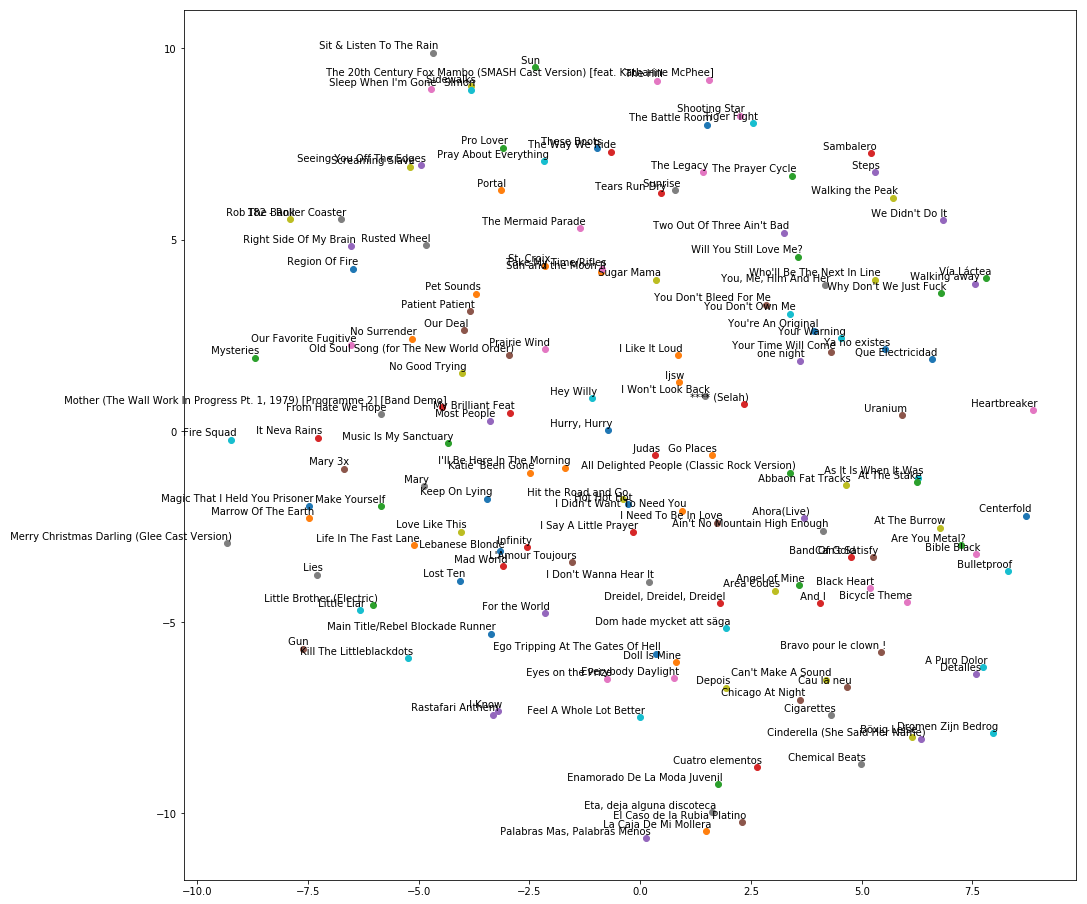

In [244]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    plt.annotate(label_format(labels[i], 2),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [31]:
#nep on train 
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(train, k)
display((hits/tries, ndgc/tries, tries, fails))

(0.17442015804996353, 0.0498488088915784, 97311, 53438)

In [30]:
#nep on test
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(test, k)
display((hits/tries, ndgc/tries, tries, fails))

(0.17181596843254135, 0.04907549546430419, 23822, 13866)

## Appendix

In [113]:
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training.
#If 0, and negative is non-zero, negative sampling will be used.

#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many 
#“noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

#model = gensim.models.Word2Vec(documents, min_count=1, workers=16, sg=1, size = 300, hs=1, window = 5)
#model.train(documents,total_examples=len(documents),epochs=1)

#window_size window-size
#it number of epochs 
#sample sub-sampling parameter
#power-alpha negative sampling distribution parameter

#window_size=3
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.0001 
#power_alpha=-0.5

#other
#size_embedding=50
#neg_sample=5
#workers=10
#min_count=5 #cold start?

#window_size=7
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.001 
#power_alpha=0.025

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 #cold start?


#model = gensim.models.Word2Vec(test, size=size_embedding, window=window_size,
#                 min_count=min_count, workers=workers, sg=1, iter=it,
#                 sample=sample, negative=neg_sample, alpha=power_alpha)

#model.train(test,total_examples=len(test), epochs=model.iter)